# Notebook 07. Introduction to RL applied to Recommender Systems

© 2019-2022, Anyscale. All Rights Reserved <br>
📖 [Back to Table of Contents](./ex_00_rllib_notebooks_table_of_contents.ipynb)<br>
➡️ [Next notebook](./ex_06_rllib_end_to_end_demo.ipynb) <br>
⬅️ [Previous notebook](./ex_04_offline_rl_with_rllib.ipynb) <br>

### Learning objectives
In this this tutorial, you will learn how to:

 * [Intro RecSys with RL](#recsys_rl)
 * [Create a RecSys RL environment](#recsys_env)
 * [Train a Contextual Bandit on the environment](#cb)
 * [Train using a RL Offline algorithm on the environment](#offline)
 
 
 find RLlib algos to train policy models on environments.
 

## Intro RecSys with RL <a class="anchor" id="recsys_rl"></a>

A Recommender System <b>(RecSys)</b> suggests items that are most pertinent to a particular user.  Examples of recommender systems include:
<ul>
    <li>Movie/video/music recommendations (Netflix/YouTube/Spotify)</li>
    <li>Online shopping recommendations (Amazon/Shopify)</li>
    <li>Filtering your feed as you scroll (Twitter/Instagram)</li>
</ul>

<b>Two main approaches to training algorithms</b> for RecSys are: 
<ol>
    <li>Traditional Machine Learning <b>(ML)</b></li>
    <li>Reinforcement Learning <b>(RL)</b></li>
    </ol>

<b>In the traditional ML method</b>, data is gathered about users interactions with items.  Matrix factorization is often used to turn this data into trainable representations of users and items ("embeddings" or features or X's), and the views or actions by users of those items (dependent variable or y's). A ranking algorithm (e.g. collaborative filtering) is trained on all the data at once as if all the actions happend during the same time step.  Such a <b><i>static</i> </b>, fixed model is useful when there are millions of items and users, since learning from all data at once in <b>batch learning</b> is efficient.

<b>In RL</b>, users interact with offers repeatedly over time.  This <b><i>dynamic</i></b> model is iteratively trained based on 
the last observation, action, and reward.  One caveat with RL, since a recommendation needs to be calculated at every time step, only a pre-selected handful of top candidate items per user (from the traditional ML ranking model) is presented in the simulation environment.  

<b>Online RL deployed to production in RecSys</b> takes as input the top-K ranked and ordered recommendations per user, keeps the user and item feature embeddings as context, but optimizes a sequence of user in-session interactions <b>real-time</b> using live results.  

<img src="./images/recsys_overview.png" width="100%"/>

<b>Offline RL in RecSys</b> uses offline data to explore a previous training run (or production) recommender model policy, implicitly through the data.  “Serendipitous” aspects of user experience can be explored through offline RL, since random actions the user did not historically take can be tried in the simulation.

<div class="alert alert-block alert-success">    
    <b>💡 Online vs Offline RL, when the algorithm learning from an environment is: </b> <br><br>
    ✔️ live (typically gaming platforms or complex systems simulations), this is called <b>online RL</b> and evaluation during training is <b>on-policy</b>. The live environment could also be in production. <br><br>
    ✔️ trained using data (could be log files of users interactions with items) converted into trajectory sequences of tuples, this is called <b>offline RL</b> and evaluation during training is <b>off-policy</b>, because the policy (RL word for model) used to log the data is different from the policy used to explore the data. Off-policy evaluation is also called <b>counterfactual evaluation</b>.</b> 
</div>

<br>

## Create a RecSys RL Environment <a class="anchor" id="recsys_env"></a>

As we learned in the first 2 lessons, the first step to training a RL RecSys policy model is to create an <b>environment</b> that can interact with a RL Algorithm to train a recommender agent. 

In this notebook, we will use <b><a href="https://github.com/google-research/recsim">Google's RecSim environment</a></b>, which was developed for the YouTube recommendation problem.  The environment is <i>Timelimit-based</i>, meaning the termination condition for an episode will be after a fixed number (60) of videos are watched. The RecSim environment consists of:

<img src="./images/recsim_environment.png" width="90%" />

* <b>Document Model</b>, in the range [0, 1].  
<ul>
    <li>On the 0-end of the scale, <b>"sweet"</b> documents lead to large amounts of <b>"click bait"</b> or immediate engagement. Sweetness values are drawn from ln Normal(μsweet, σsweet).</li>
    <li>On the 1-end of the scale, documents termed <b>kale</b>, are less click-bait, but tend to <b>increase user long-term satisfaction</b>. Kale values are drawn from ln Normal(μkale, σkale)</li>
    <li>Mixed doc values are drawn from linear interpolation between parameters of the two distributions in proportion to their kaleness.</li>
    </ul>
* <b>User Model</b>, empty vectors.  <i>Since user features are so business-dependent, RecSim out-of-the-box does not include any user features.</i>  User features, typically imported from real data, could contain: 
<ul>
    <li>evolving, unknown contexts (interests, preferences, satisfaction, activity, mood)</li>
    <li>unobservable events that could impact user behavior (personalized promotions, interuptions that cause turning off a video such as because someone rang their doorbell).</li>
    </ul>
* <b>Rewards</b>, or user satisfaction after their choice, modeled in the range [0, 1] that stochastically (and slowly) increases or decreases with the consumption of different types of content; kale or sweetness.  


<b>RLlib comes with 3 RecSim environments</b>  <br>
<div class="alert alert-block alert-success">    
👉 <b>Long Term Satisfaction</b> (used in this tutorial) <br>
- Interest Evolution <br>
- Interest Exploration <br>
</div>

<br>

In [1]:
# import libraries
import random
import time
import numpy as np
from scipy.stats import linregress, sem
import pandas as pd
import matplotlib.pyplot as plt
import ray
from ray import tune
from ray.tune.logger import pretty_print
from pprint import pprint
print(f"ray: {ray.__version__}")

# silence the many tensorflow warnings
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
import gym
import recsim

print(f"tensorflow: {tf.__version__}")
print(f"gym: {gym.__version__}")

# Import the built-in RecSim exapmle environment: "Long Term Satisfaction", ready to be trained by RLlib.
from ray.rllib.examples.env.recommender_system_envs_with_recsim import LongTermSatisfactionRecSimEnv


ray: 3.0.0.dev0
tensorflow: 2.6.0
gym: 0.21.0


In [2]:
# Modifying wrapper around the LTS (Long Term Satisfaction) env:
# - allows us to tweak the user model (and thus: reward behavior)
# - adds user's current satisfaction value to observation

class LTSWithStrongerDissatisfactionEffect(gym.ObservationWrapper):

    def __init__(self, env):
        # Tweak incoming environment.
        env.environment._user_model._user_sampler._state_parameters.update({
            "sensitivity": 0.058,
            "time_budget": 120,
            "choc_stddev": 0.1,
            "kale_stddev": 0.1,
            #"innovation_stddev": 0.01,
            #"choc_mean": 1.25,
            #"kale_mean": 1.0,
            #"memory_discount": 0.9,
        })

        super().__init__(env)

        # Adjust observation space.
        if "response" in self.observation_space.spaces:
            self.observation_space.spaces["user"] = \
                gym.spaces.Box(0.0, 1.0, (1, ), dtype=np.float32)
            for r in self.observation_space["response"]:
                if "engagement" in r.spaces:
                    r.spaces["watch_time"] = r.spaces["engagement"]
                    del r.spaces["engagement"]
                    break

    def observation(self, observation):
        if "response" in self.observation_space.spaces:
            observation["user"] = np.array(
                [self.env.environment._user_model._user_state.satisfaction])
            for r in observation["response"]:
                if "engagement" in r:
                    r["watch_time"] = r["engagement"]
                    del r["engagement"]
        return observation


# Add the wrapping around 
tune.register_env("modified-lts", 
                  lambda env_config: LTSWithStrongerDissatisfactionEffect(
                      LongTermSatisfactionRecSimEnv(env_config)))

print("ok; registered the string 'modified-lts' to be used in RLlib configs (see below)")


ok; registered the string 'modified-lts' to be used in RLlib configs (see below)


In [3]:
# How to make RecSim environments?

# Env with 20 candidate items and a slate-size of 2.
# Try to strengthen the dissatisfaction effect on the engagement

# Step 1. define a config dictionary
env_config_20 = \
    {
        # The number of possible documents/videos/candidates that we can recommend
        "num_candidates": 20,  
        # The number of recommendations that we will be making
        "slate_size": 2,  # MultiDiscrete([20, 20]) -> Discrete(400)
        # Set to False for re-using the same candidate doecuments each timestep.
        "resample_documents": True,
        # Convert MultiDiscrete actions to Discrete (flatten action space).
        "convert_to_discrete_action_space": True,
        # Wrap observations for RLlib bandit: Only changes dict keys ("item" instead of "doc").
        "wrap_for_bandits": True,}

# Step 2. create a RecSim environment
lts_20_2_env = LongTermSatisfactionRecSimEnv(env_config_20)

# step 3. create a modified RecSim environment
# LTSWithStrongerDissatisfactionEffect(recsim_env)
modified_lts_20_2_env = \
    LTSWithStrongerDissatisfactionEffect(lts_20_2_env)

print(type(modified_lts_20_2_env))


<class '__main__.LTSWithStrongerDissatisfactionEffect'>


In [4]:
# inspect the gym spec for the environment
print(f"env: {modified_lts_20_2_env}")

# print gym Spaces
if isinstance(modified_lts_20_2_env.action_space, gym.spaces.Space):
    print()
    print(f"action space: {modified_lts_20_2_env.action_space}")
if isinstance(modified_lts_20_2_env.observation_space, gym.spaces.Space):
    print()
    print(f"observation space: ", end="")
    print(pretty_print(dict(modified_lts_20_2_env.observation_space)))
    # pprint(modified_lts_20_2_env.observation_space)

# reset env
obs = modified_lts_20_2_env.reset()

# get a random action
range_actions = modified_lts_20_2_env.action_space.n
action = random.randint(0,range_actions-1)
print(f"action: {action}, ", end="")

# get the next obs, next reward, done based on the action
obs, reward, done, _ = modified_lts_20_2_env.step(action)
# print(f"obs: ", end="")
# pprint(obs)
print(f"reward: {reward:.2f}, ", end="")
print(f"done: {done}")


env: <LTSWithStrongerDissatisfactionEffect<_RecSimEnv<RecSimObservationBanditWrapper<MultiDiscreteToDiscreteActionWrapper<RecSimObservationSpaceWrapper<RecSimResetWrapper<RecSimGymEnv instance>>>>>>>

action space: Discrete(400)

observation space: item: "Box([[-1.]\n [-1.]\n [-1.]\n [-1.]\n [-1.]\n [-1.]\n [-1.]\n [-1.]\n [-1.]\n\
  \ [-1.]\n [-1.]\n [-1.]\n [-1.]\n [-1.]\n [-1.]\n [-1.]\n [-1.]\n [-1.]\n [-1.]\n\
  \ [-1.]], [[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n\
  \ [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]], (20, 1),\
  \ float32)"

action: 150, reward: 9.47, done: False


From the RecSim documentation, we can see that:

<ul>
    <li><b>action</b>, is a number between 0 and num_products - 1 that represents index of products clicked, between 0 and 399 in this case. </li>
    <li><b>observation</b> will be the next session of 20 candidate products user sees, based on the user's action.
    </li>
    <li><b>reward</b> is the engagement value of the product user clicked.  Notice RecSim has a simplified assumption that the user always clicks the 1st-position product recommended to the user.</li>
    <li><b>done</b> is a True/False flag indicating if the episode or user's timeline (fixed 60 sessions) is over.</li>
    <li><b>info</b> currently not used, so it is always an empty dictionary.</li>
    </ul>

<b>Get an environment baseline</b>

It is always best practice, before training an algorithm, to run through the environment and record the mean reward as a baseline.

<div class="alert alert-block alert-success">
💡 For this environment, we will calculate 3 baselines: <br>
    <ul>
        <li>Random baseline: pick randomly every time</li>
        <li>Greedy sweet baseline: always pick the sweetest item </li>
        <li>Greedy kale baseline: always pick the kaleist item </li>
    </ul>
</div>

In [5]:
# Function that measures and outputs the random baseline reward.
# This is the expected accumulated reward per episode, if we act randomly (recommend random items) at each time step.
def calc_baseline(env, 
                  baseline_type="random",
                  episodes=100, verbose=False):

    # Reset the env.
    obs = env.reset()

    # Number of episodes already done.
    num_episodes = 0
    # Current episode's accumulated reward.
    episode_reward = 0.0
    # Collect all episode rewards here to be able to calculate a random baseline reward.
    episode_rewards = []

    # Enter while loop (to step through the episode).
    while num_episodes < episodes:
        # Produce an action
        action_random = env.action_space.sample()
        action_sweetest = np.argmax(obs['item'])
        action_kaleiest = np.argmin(obs['item'])
        if baseline_type == "random":
            action = action_random
        elif baseline_type == "sweetest":
            action = action_sweetest
        elif baseline_type == "kaleist":
            action = action_kaleiest

        # Send the action to the env's `step()` method to receive: obs, reward, done, and info.
        obs, reward, done, _ = env.step(action)
        episode_reward += reward

        # Check, whether the episde is done, if yes, reset and increase episode counter.
        if done:
            if verbose:
                print(f"Episode done - accumulated reward={episode_reward}")
            elif num_episodes % 99 == 0:
                print(f" {num_episodes} ", end="")
            elif num_episodes % 9 == 0:
                print(".", end="")
            num_episodes += 1
            env.reset()
            episode_rewards.append(episode_reward)
            episode_reward = 0.0

    # Print out and return mean episode reward (and standard error of the mean).
    env_mean_random_reward = np.mean(episode_rewards)
    env_sd_reward = sem(episode_rewards)

    print(f"\nMean {baseline_type} baseline reward: {env_mean_random_reward:.2f}+/-{sem(episode_rewards):.2f}")

    return env_mean_random_reward, sem(episode_rewards)


In [6]:
# Calculate a baseline type: random, sweetest, or kaleist
lts_20_2_mean_kaleist_reward, _ = \
    calc_baseline(lts_20_2_env, 
                  baseline_type="kaleist",
                  episodes=100)
lts_20_2_mean_random_reward, _ = \
    calc_baseline(lts_20_2_env, 
                  baseline_type="random",
                  episodes=100)
lts_20_2_mean_sweetest_reward, _ = \
    calc_baseline(lts_20_2_env, 
                  baseline_type="sweetest",
                  episodes=100)

# Kaleist baseline: 1085.60+/-1.01   # smallest
# Random baseline: 1156.79+/-1.12    # next biggest
# Sweetest baseline: 1162.94+/-1.08  # biggest

 0 .......... 99 
Mean kaleist baseline reward: 1083.80+/-1.06
 0 .......... 99 
Mean random baseline reward: 1156.63+/-1.13
 0 .......... 99 
Mean sweetest baseline reward: 1163.50+/-1.17


## Train a Contextual Bandit on the environment <a class="anchor" id="cb"></a>

A Bandit session is one where we have an opportunity to recommend the user an item and observe their behaviour. We receive a reward if they click.

<ol>
    <li>Open RLlib docs <a href="https://docs.ray.io/en/master/rllib/rllib-algorithms.html">and navigate to the Algorithms page.</a></li>
    <li>Scroll down and click url of algo you want to use, e.g. <i><b>Bandits</b></i></li>
    <li>On the <a href="https://docs.ray.io/en/master/rllib/rllib-algorithms.html#bandits">algo docs page </a>, click on the link <i><b>Implementation</b></i>.  This will open the <a href="https://github.com/ray-project/ray/blob/master/rllib/algorithms/bandit/bandit.py">algo code file on github</a>.</li>
    <li>Search the github code file for the word <i><b>config</b></i></li>
    <li>Typically the docstring example will show: </li>
    <ol>
        <li>Example code implementing RLlib API, then </li>
        <li>Example code implementing Ray Tune API.</li>
    </ol>
    <li>Scroll down to the config <b>__init()__</b> method</li>
    <ol>
            <li>Algorithm default hyperparameter values are here.</li>
    </ol>
    </ol>

In [7]:
# Select RLlib Bandit algorithm w/Upper Confidence Bound (UCB) exploration
# and find that algorithm's config class

# config is an object instead of a dictionary since Ray version >= 1.13
from ray.rllib.algorithms.bandit import BanditLinUCBConfig

In [8]:
# # uncomment below to see the long list of default config values
# print(f"Bandit's default config is:")
# print(pretty_print(BanditLinUCBConfig().to_dict()))

# Create a defaut Algorithmconfig:
bandit_config = BanditLinUCBConfig()

# Create the Env config
env_config_20 = \
    {
        # The number of possible documents/videos/candidates that we can recommend
        "num_candidates": 20,  
        # The number of recommendations that we will be making
        "slate_size": 2,  # MultiDiscrete([20, 20]) -> Discrete(400)
        # Set to False for re-using the same candidate doecuments each timestep.
        "resample_documents": True,
        # Convert MultiDiscrete actions to Discrete (flatten action space).
        "convert_to_discrete_action_space": True,
        # Wrap observations for RLlib bandit: Only changes dict keys ("item" instead of "doc").
        "wrap_for_bandits": True,}

# Set it up for the correct environment:
bandit_config.environment(env="modified-lts", env_config=env_config_20)

# Decide if you want torch or tensorflow DL framework
bandit_config.framework("torch")

# Set up evaluation:
bandit_config.evaluation(
    # Run evaluation once per `train()` call.
    evaluation_interval=10,
    # Use separate resources (RLlib rollout workers).
    evaluation_num_workers=2,
    # Run 20 episodes per evaluation (per iteration) 
    # -> 10 per eval worker (we have 2 eval workers).
    evaluation_duration=20,
    evaluation_duration_unit="timesteps",
    # # Run evaluation alternatingly with training (not in parallel).
    # evaluation_parallel_to_training=False,
)

# Create a new training config
# override certain default algorithm config values
bandit_config.rollouts(
    num_rollout_workers=2, 
    num_envs_per_worker=4)

bandit_config.resources(num_gpus=0)

bandit_config.debugging(
    seed=415, 
    # Set the log level to DEBUG, INFO, WARN, or ERROR 
    log_level="ERROR")

print(type(bandit_config))


<class 'ray.rllib.algorithms.bandit.bandit.BanditLinUCBConfig'>


In [9]:
# To start fresh, restart Ray in case it is already running
if ray.is_initialized():
    ray.shutdown()
    
# Use the config object's `build()` method for generating
# an RLlib Algorithm instance that we can then train.
linucb_algo = bandit_config.build()
print(f"Algorithm type: {type(linucb_algo)}")

start_time = time.time()

# train the Bandit Algorithm instance for n iterations (timesteps)
rewards = []
n_timesteps = 100
for i in range(n_timesteps):
    # Run a single timestep in the environment and update
    # the model immediately on the received reward.
    result = linucb_algo.train()
    
    # Extract reward from results.
    rewards.append(result["episode_reward_mean"])
    
    if i % 99 == 0:
        print(f"\nIteration={i}, ", end="")
        print(f"Mean Bandit Reward={result['episode_reward_mean']:.2f}",end="")
        try:
            print(f"+/-{np.std(rewards[9:]):.2f}")
        except:
            print()
    elif i % 9 == 0:
        print(".", end="")

print("The trials took", time.time() - start_time, "seconds\n")

# To stop the Algorithm and release its blocked resources, use:
linucb_algo.stop()
# To start fresh, restart Ray in case it is already running
if ray.is_initialized():
    ray.shutdown()

2022-08-08 14:50:51,762	ERROR services.py:1376 -- Failed to start the dashboard: Failed to start the dashboard, return code 1
 The last 10 lines of /tmp/ray/session_2022-08-08_14-50-49_658666_22384/logs/dashboard.log:
  File "/Users/christy/miniforge3/envs/rllib2/lib/python3.8/site-packages/aiohttp/web_urldispatcher.py", line 1200, in add_routes
    registered_routes.extend(route_def.register(self))
  File "/Users/christy/miniforge3/envs/rllib2/lib/python3.8/site-packages/aiohttp/web_routedef.py", line 98, in register
    resource = router.add_static(self.prefix, self.path, **self.kwargs)
  File "/Users/christy/miniforge3/envs/rllib2/lib/python3.8/site-packages/aiohttp/web_urldispatcher.py", line 1124, in add_static
    resource = StaticResource(
  File "/Users/christy/miniforge3/envs/rllib2/lib/python3.8/site-packages/aiohttp/web_urldispatcher.py", line 559, in __init__
    raise ValueError(f"No directory exists at '{directory}'") from error
ValueError: No directory exists at '/Users/

Algorithm type: <class 'ray.rllib.algorithms.bandit.bandit.BanditLinUCB'>

Iteration=0, Mean Bandit Reward=nan+/-nan


/Users/christy/miniforge3/envs/rllib2/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/christy/miniforge3/envs/rllib2/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/christy/miniforge3/envs/rllib2/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


..........
Iteration=99, Mean Bandit Reward=1163.89+/-1.45
The trials took 16.301603078842163 seconds



/var/folders/0g/jfs_l_113_356_c0rfp4jd8c0000gn/T/ipykernel_22384/726157932.py:8: RuntimeWarning: Mean of empty slice
  y = [np.nanmean(rewards[max(i - smoothing_win, 0):i + 1])


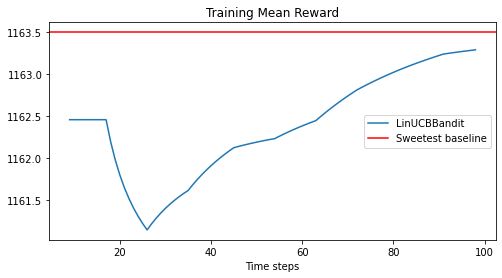

In [10]:
# Plot per-timestep (episode) rewards.
fig, ax = plt.subplots(1,1,figsize=(8,4))

# collect plot data from bandit rewards
start_at = 4  #bandit rewards are nan for 1st 3 iterations
smoothing_win = 100
x = list(range(start_at, len(rewards)-1))
y = [np.nanmean(rewards[max(i - smoothing_win, 0):i + 1]) 
     for i in range(start_at, len(rewards)-1)]

# plot bandit rewards
ax.plot(x, y, label="LinUCBBandit")

# Add mean random baseline reward (red line).
plt.axhline(y=lts_20_2_mean_sweetest_reward, 
            color="r", 
            linestyle="-",
            label="Sweetest baseline")

# Add legend
ax.legend(loc='center right', frameon=True)

# Add titles
plt.title("Training Mean Reward")
plt.xlabel("Time steps")

plt.plot();


Comparing our algorithms over 100 timesteps:
<ul>
    <li>Kaleist baseline: 1085.60+/-1.01 </li>
    <li>Random baseline: 1156.79+/-1.12 </li>
    <b><li>Sweetest baseline: 1162.94+/-1.08 </li>
        <li>Bandit mean reward = 1163.89+/-1.45</li></b>
    </ul>

<div class="alert alert-block alert-success">
🤔 Notice that the bandit mean reward is suspiciously the same as the sweetest baseline! <br>
</div>

In this dummy Recsim environment, we did not have any user features.  This makes the contextual bandit without any user context, i.e. without any state.  A stateless bandit cannot remember things between timesteps, so it will be exactly the most greedy policy.  

So, it makes sense that the Bandit reward = Sweetest baseline!  The context-less bandit was unable to learn anything!


## Train using a RL Offline algorithm on the environment <a class="anchor" id="offline"></a>

CRR

In [11]:
# Let's first take a look at some of this (JSON) data using pandas:
json_file = "offline_rl_data/recsys_expert.json"
df = pd.read_json(json_file, lines=True)  # don't forget lines=True -> Each line in the json is one "rollout" of 4 timesteps.
df.head()


,type,obs,actions,prev_actions,rewards,prev_rewards,dones,eps_id,unroll_id,agent_index,t,action_dist_inputs,action_logp,action_prob,advantages,value_targets
0,SampleBatch,BCJNGGhAwFEAAAAAAACsI0kAAGGABZW1UQABAPMZjBJudW...,"[[18, 2], [2, 15], [11, 14], [8, 16], [4, 18],...","[[18, 2], [18, 2], [2, 15], [11, 14], [8, 16],...","[23.29007911682129, 7.152186393737793, 2.76373...","[23.29007911682129, 23.29007911682129, 7.15218...","[False, False, False, False, False, False, Fal...","[542138261, 542138261, 542138261, 542138261, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[-0.006720410659909, 0.014437448233366, -0.00...","[-5.9771623611450195, -6.004640102386475, -5.9...","[0.0025360123254350004, 0.0024672772269690004,...","[932.8204345703125, 918.7171630859375, 920.772...","[932.8135986328125, 918.7106323242188, 920.766..."
1,SampleBatch,BCJNGGhAwFEAAAAAAACs/0cAAGGABZW1UQABAPMZjBJudW...,"[[13, 3], [16, 17], [7, 17], [8, 7], [4, 5], [...","[[14, 1], [13, 3], [16, 17], [7, 17], [8, 7], ...","[5.713678359985352, 18.23175048828125, 6.07325...","[21.042491912841797, 5.713678359985352, 18.231...","[False, False, False, False, False, False, Fal...","[1118934910, 1118934910, 1118934910, 111893491...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 3...","[[-0.003344316966831, -0.002333797048777, 0.00...","[-6.002190589904785, -5.994460582733154, -5.98...","[0.002473328262567, 0.0024925211910150004, 0.0...","[515.4043579101562, 514.835205078125, 501.6228...","[515.3938598632812, 514.8284301757812, 501.612..."
2,SampleBatch,BCJNGGhAwFEAAAAAAACsX0kAAGGABZW1UQABAPMZjBJudW...,"[[3, 17], [6, 3], [15, 17], [11, 2], [0, 12], ...","[[10, 1], [3, 17], [6, 3], [15, 17], [11, 2], ...","[14.05547046661377, 20.706499099731445, 34.158...","[4.046912670135498, 14.05547046661377, 20.7064...","[False, False, False, False, False, False, Fal...","[1466202559, 1466202559, 1466202559, 146620255...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 5...","[[-0.003262223675847, 0.008641279302537, -0.00...","[-5.993566513061523, -5.996161460876465, -5.98...","[0.002494750544428, 0.0024882853031150003, 0.0...","[221.78857421875, 209.83851623535156, 191.0375...","[221.7843475341797, 209.8271484375, 191.030960..."
3,SampleBatch,BCJNGGhAwFEAAAAAAACsCkkAAGGABZW1UQABAPMZjBJudW...,"[[10, 19], [8, 3], [18, 8], [8, 7], [16, 2], [...","[[10, 19], [10, 19], [8, 3], [18, 8], [8, 7], ...","[34.26883316040039, 21.044775009155273, 8.3825...","[34.26883316040039, 34.26883316040039, 21.0447...","[False, False, False, False, False, False, Fal...","[1418911249, 1418911249, 1418911249, 141891124...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[-0.008724463172256001, 0.0040771835483610006...","[-5.995693683624268, -5.9909610748291025, -5.9...","[0.002489449456334, 0.002501259092241, 0.00250...","[658.6182861328125, 630.65478515625, 615.76763...","[658.6080322265625, 630.6456298828125, 615.758..."
4,SampleBatch,BCJNGGhAwFEAAAAAAACsjkkAAGGABZW1UQABAPMZjBJudW...,"[[1, 8], [2, 19], [9, 1], [1, 16], [5, 2], [15...","[[6, 5], [1, 8], [2, 19], [9, 1], [1, 16], [5,...","[3.041858196258545, 8.18496322631836, 62.71932...","[3.607390880584717, 3.041858196258545, 8.18496...","[False, False, False, False, False, False, Fal...","[450621694, 450621694, 450621694, 450621694, 4...","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 3...","[[-0.002998510375618, -0.00399568863213, -0.00...","[-5.999508380889893, -5.996327877044678, -5.98...","[0.0024799711536610002, 0.002487871097

In [12]:
# Import the config class of the algorithm, we would like to train with: CRR.
from ray.rllib.algorithms.crr import CRRConfig


In [13]:
# Create a defaut CRR config:
config = CRRConfig()

# Set it up for the correct environment:
# NOTE: We said above that we wouldn't really have an environment available (so how can
# we set one up here??).
# The following is only to tell the algorithm, which environment our offline data was actually taken from.
config.environment(env="modified-lts")
# If you really really don't have an environment, set `env=None` here and additionally define your action- and
# observation spaces.
# config.environment(env=None, action_space=..., observation_space=...)

#################################################
# This is the most important piece of code 
# in this notebook:
# It explains how to point your 
# algorithm to the correct offline data file
# (instead of a live-environment).
#################################################
config.offline_data(
    input_="dataset",
    input_config={
        # If you feel daring here, use the `pendulum_beginner.json` file instead of the expert one here.
        # You may need to train a little longer, then, in order to get a decent policy.
        # But since you have the actual Pendulum environment available for evaluation, you should be able
        # to perfectly stop learning once a good episode reward (> -300.0) has been reached.
        "paths": os.path.join(os.getcwd(), "offline_rl_data/pendulum_expert.json"),
        "format": "json",
    },
    # The (continuous) actions in our input files are already normalized
    # (meaning between -1.0 and 1.0) -> We don't have to do anything with them prior to
    # computing losses.
    actions_in_input_normalized=True,
)

# RLlib's CRR is a very new algorithm (since 1.13) and only supports
# the PyTorch framework thus far. We'll provide a tf version in the near future.
config.framework("torch")

# Set up evaluation as follows:
config.evaluation(
    # Run evaluation once per `train()` call.
    evaluation_interval=1,
    # Use a separate resource ("RLlib rollout worker")
    evaluation_num_workers=1,

    # # Use separate resources (RLlib rollout workers).
    # evaluation_num_workers=2,

    # Run 20 episodes per evaluation (per iteration) -> 10 per eval worker (we have 2 eval workers).
    evaluation_duration=20,
    evaluation_duration_unit="episodes",

    # Use a slightly different config for the evaluation:
    evaluation_config={
        # - Use a real environment (so we can fully trust the evaluation results, rewards, etc..)
        "input": "sampler",
        # - Switch off exploration for better (less stochastic) action computations.
        "explore": False,
    },

    # Run evaluation alternatingly with training (not in parallel).
    evaluation_parallel_to_training=False,
)

print(type(config))


<class 'ray.rllib.algorithms.crr.crr.CRRConfig'>


In [14]:
evaluation_interval = 100   #100, num training episodes to run between eval steps
verbosity = 2 # Tune screen verbosity

experiment_results = tune.run("CRR", 
                    
    # Stopping criteria whichever occurs first: average reward over training episodes, or ...
    stop={#"episode_reward_mean": 400, # stop if achieve 400 out of max 500
          "training_iteration": 10,  # stop if achieved 100 episodes
          # "timesteps_total": 100000,  # stop if achieved 100,000 timesteps
          },  
              
    # training config params
    config = config.to_dict(),
                    
    #redirect logs instead of default ~/ray_results/
    local_dir = relative_checkpoint_dir, #relative path
         
    # set frequency saving checkpoints >= evaulation_interval
    checkpoint_freq = checkpoint_freq,
    checkpoint_at_end=True,
         
    # Reduce logging messages
    verbose = verbosity,
    )

print("Training completed.")

NameError: name 'relative_checkpoint_dir' is not defined

### Exercises

1. 

### Homework

1. 

### References

* 

📖 [Back to Table of Contents](./ex_00_rllib_notebooks_table_of_contents.ipynb)<br>
➡️ [Next notebook](./ex_06_rllib_end_to_end_demo.ipynb) <br>
⬅️ [Previous notebook](./ex_04_offline_rl_with_rllib.ipynb) <br>